In [82]:
# import the necessary packages
import tensorflow as tf
import numpy as np
import random
import os


In [2]:
# path to training and testing data
TRAIN_DATASET = "Training"
TEST_DATASET = "Validation"

# model input image size
IMAGE_SIZE = (100,100)

# batch size and the buffer size
BATCH_SIZE = 5
BUFFER_SIZE = BATCH_SIZE * 2

# define autotune
AUTO = tf.data.AUTOTUNE

# define the training parameters
LEARNING_RATE = 0.0001
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 10
EPOCHS = 10

# define the path to save the model
OUTPUT_PATH = "output"
MODEL_PATH = os.path.join(OUTPUT_PATH, "siamese_network")
OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_PATH, "output_image.png")

In [28]:
class MapFunction():
	def __init__(self, imageSize):
		# define the image width and height
		self.imageSize = imageSize
	def decode_and_resize(self, imagePath):
		# read and decode the image path
		image = tf.io.read_file(imagePath)
		image = tf.image.decode_jpeg(image, channels=3)
		# convert the image data type from uint8 to float32 and then resize
		# the image to the set image size
		image = tf.image.convert_image_dtype(image, dtype=tf.float32)
		image = tf.image.resize(image, self.imageSize)
		# return the image
		return image
	def __call__(self, positive, negative):
		
		positive = self.decode_and_resize(positive)
		negative = self.decode_and_resize(negative)
		# return the anchor, positive and negative processed images
		return ( positive, negative)

# Contrastive Loss Generator

In [ ]:
class PairGenerator:
    def __init__(self, datasetPath):
        self.fruitNames = list()  # path to dir with fruits
        for folderName in os.listdir(datasetPath):
            absoluteFolderName = os.path.join(datasetPath, folderName)
            numImages = len(os.listdir(absoluteFolderName))
            if numImages > 1:
                self.fruitNames.append(absoluteFolderName)
        self.allFruit = self.generate_all_fruit_dict()
    def generate_all_fruit_dict(self):
        allFruit = dict()
        
        for fruitName in self.fruitNames:
            imageNames = os.listdir(fruitName) # all names of photo one fruit
            fruitPhotos = [
                os.path.join(fruitName, imageName) for imageName in imageNames
            ]
            allFruit[fruitName] = fruitPhotos
        return allFruit #all path photo in dict
            
    def get_next_element(self):
        
        for _ in range(5):
            imageNames = random.choice(self.fruitNames)
            temporaryNames = self.fruitNames.copy()
            temporaryNames.remove(imageNames)
            negativeNames = random.choice(temporaryNames)

            imagePhoto=random.choice(self.allFruit[imageNames])
            positivePhoto=random.choice(self.allFruit[imageNames])
            negativePhoto=random.choice(self.allFruit[negativeNames])
        
            yield (imagePhoto, positivePhoto, 1)
            yield (imagePhoto, negativePhoto, 0)
            


            
            

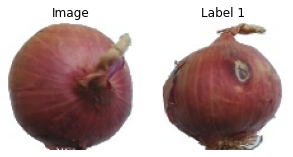

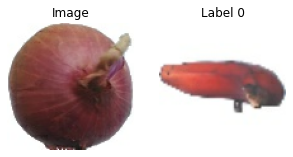

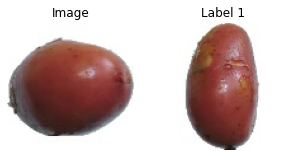

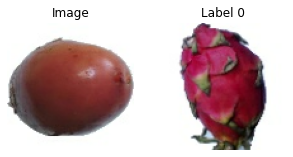

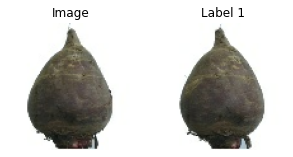

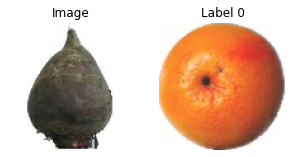

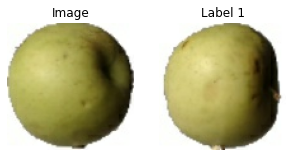

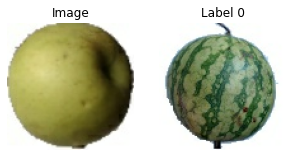

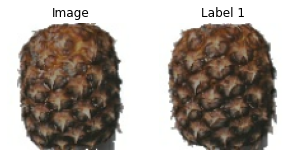

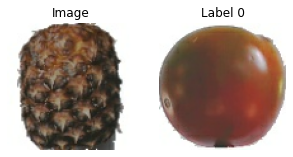

In [89]:

import matplotlib.pyplot as plt

image_processor = MapFunction(IMAGE_SIZE)
dataset_path = "fruits-360_dataset/fruits-360/Training"

pair_generator = PairGenerator(dataset_path)


for  imagePath, neg_posPath, label in pair_generator.get_next_element():
    # Process images using MapFunction
    image, neg_pos_image = image_processor( imagePath, neg_posPath)
            
    # Display the images10
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')
    axes[1].imshow(neg_pos_image)
    axes[1].set_title(f"Label {label}")
    axes[1].axis('off')

    plt.show()




In [78]:
len(pair_generator.allFruit)

131

# Loading data


In [98]:
dataset=tf.data.Dataset.from_generator(pair_generator.get_next_element,
                                        output_signature=(tf.TensorSpec(shape=(100, 100, 3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(100, 100, 3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(), dtype=tf.int32)))
                                      


In [84]:
input = tf.keras.layers.Input(shape=(100, 100, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(131, activation="tanh")(x)
embedding_network = tf.keras.Model(input, x)